# UMAP Plot

Use the bodies of text that describes a feed to create a UMAP Plot.

## Load Features

Load all information for all feeds or posts in the database that have features.

Store the results in the *feeds* or *posts* dicts.

In [9]:
import sqlite3
import umap, umap.plot
from sklearn.feature_extraction.text import CountVectorizer
from corextopic import corextopic as ct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# stop words lists
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# stores the posts in a dict
feeds = dict()

print('Loading feed info...')

# connect to the db
conn = sqlite3.connect('feeds.db')
c = conn.cursor()
    
# select only the feeds for which the body of text 
# has already been generated
c.execute('SELECT url, text, title, description FROM feeds WHERE text IS NOT NULL AND title IS NOT NULL AND description IS NOT NULL;')
for entry in c.fetchall():
    feeds[entry[0]] = {
        'text': entry[1],
        'title': entry[2],
        'description': entry[3]
    }        

print('Loaded info for ' + str(len(feeds)) + ' feeds')

Loading feed info...
Loaded info for 10007 feeds


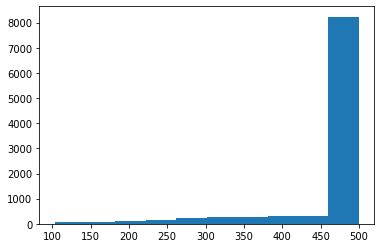


Minimum length of text: 103
Average length of text: 468.5280303787349
Maximum length of text: 500


In [10]:
lengths = [len(f['text'].split()) for f in feeds.values()]

plt.hist(lengths)
plt.show()

print()
print('Minimum length of text:', min(lengths))
print('Average length of text:', np.average(lengths))
print('Maximum length of text:', max(lengths))


## Vectorize Documents

Create a doc-word matrix based on the data in the *feeds* dict. 

Each row in the matrix corresponds to a feed and each column corresponds to a word.

In [11]:
# define a function that will be used to pre-process data before being vectorized
def custom_preprocessor(text):

    # convert to lower case
    text = text.lower()

    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # lemmatize text using WordNet
    lemmatizer = WordNetLemmatizer()

    lemmatized_words = list()
    for word in word_tokenize(text):

        # determine the part-of-speech tag for the word
        pos = nltk.pos_tag([word])[0][1][0] # only the first letter matters (hence the 0 at the end)

        # default to noun if the tag does not fall into the categories accepted by lemmatize()
        if pos != 'V' and pos != 'N' and pos != 'R' and pos != 'J':
            pos = 'N'
        if pos == 'J':
            pos = 'A'
        pos = pos.lower()

        # lemmatize the word and add to list
        lemmatized_words.append(lemmatizer.lemmatize(word, pos))

    # join the lemmatized words together
    text = ' '.join(lemmatized_words)   

    return text 
    

corpus = list(f['text'] for f in feeds.values())

# generate a stop words list by joining multiple predefined lists
stopwords_list = list(set(sw_nltk) | set(sw_spacy) | set(STOPWORDS) | set(ENGLISH_STOP_WORDS))

# custom stop words (was given warning that these are not included in stop_words)
stopwords_list.extend(['doe', 'ha', 'le', 'need', 'sha', 'wa', 'wo'])

vectorizer = CountVectorizer(max_features=20000, preprocessor=custom_preprocessor, binary=True, stop_words=stopwords_list)
doc_word = vectorizer.fit_transform(corpus)

# get the words (column labels)
words = vectorizer.get_feature_names()

# get the docs/feeds (keys of the feeds dict)
docs = list(feeds.keys())

print('Shape of doc-word matrix: ', str(doc_word.shape))
print('Number of documents (posts): ', str(len(docs)))
print('Number of words (features): ', str(len(words)))

Shape of doc-word matrix:  (10007, 20000)
Number of documents (posts):  10007
Number of words (features):  20000


In [12]:
# show the features of a feed after processing
indices = vectorizer.transform([feeds['https://charlotteslivelykitchen.com/feed/']['text']]).indices
features = list()
for index in indices:
    features.append(words[index])

print(features)



['adapt', 'almond', 'appear', 'aquafaba', 'autumn', 'bakes', 'baking', 'beautiful', 'biscuit', 'bonus', 'bundt', 'buttercream', 'cake', 'calculator', 'centre', 'charlotte', 'cheese', 'chickpea', 'chip', 'chocolate', 'chunk', 'classic', 'colourful', 'cooking', 'cooky', 'cream', 'crunchy', 'crush', 'cupcake', 'decorate', 'delicious', 'drizzle', 'easily', 'easter', 'egg', 'enjoy', 'ensure', 'finish', 'fit', 'flavour', 'fluffy', 'fruit', 'ganache', 'homemade', 'ice', 'idea', 'kitchen', 'layer', 'lemon', 'light', 'lightly', 'lively', 'loaf', 'lot', 'lotus', 'lover', 'macarons', 'milk', 'mini', 'mix', 'moist', 'mousse', 'oreo', 'outside', 'packed', 'perfect', 'piece', 'plus', 'post', 'pumpkin', 'range', 'recipe', 'rectangular', 'release', 'round', 'sandwich', 'simple', 'smooth', 'soft', 'spice', 'sponge', 'spot', 'spread', 'sprinkle', 'square', 'stick', 'sweet', 'taste', 'tin', 'tip', 'tool', 'topped', 'treat', 'trick', 'twist', 'ultimate', 'use', 'vanilla', 'vegan', 'version']


In [13]:
# get the number of unique words in the corpus
vocabulary = list()
for f in feeds.values():
    text = f['text']
    vocabulary.extend(text.split())
    
print(len(set(vocabulary)))


324325


## CorEx Topic Modelling

Use the CorEx library to infert topics from the bodies of text of the feeds.

### Train the Model

In [17]:
# train the CorEx topic model
topic_model = ct.Corex(n_hidden=25, words=words, docs=docs, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words, docs=docs)

### Plot the Distribution of TCs For Each Topic

Use the plot to select an appropriate number of topics. Keep adding topics until additional ones do not significantly contribute to the overall TC.

Total Correlation of the model: 33.3412232398708


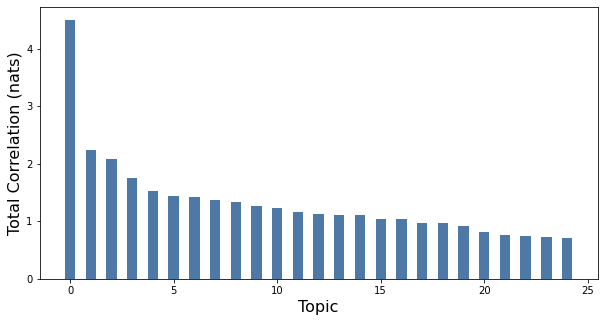

In [18]:
print('Total Correlation of the model:', str(topic_model.tc))

plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

### Display All Topics Generated

In [20]:
topics = topic_model.get_topics(n_words=10)
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: recipe, delicious, food, dish, ingredient, bake, flavor, sweet, sauce, meal
1: health, patient, treatment, disease, symptom, medical, body, pain, therapy, care
2: business, company, customer, market, industry, marketing, investment, service, investor, financial
3: user, data, technology, software, platform, digital, application, web, app, google
4: color, design, flower, fabric, warm, plant, water, dry, green, colour
5: love, holiday, christmas, perfect, fun, gift, season, beautiful, favorite, winter
6: thing, time, think, like, feel, want, little, lot, day, know
7: travel, city, destination, south, road, hotel, north, country, tourist, west
8: th, january, december, november, easy, saturday, week, october, join, st
9: law, court, attorney, political, legal, biden, public, act, police, trump
10: music, god, jesus, song, album, church, christian, christ, lord, faith
11: skin, skincare, beauty, hair, makeup, cosmetic, una, dental, glow, lip
12: help, important, improve, strategy, prov

### Assign a Topic to Each Feed

For each feed, assign it the topic such that the feed has the highest probability of belonging to that topic.

In [21]:
# Make a hard assignment of one topic per document
hard_labels = np.zeros(doc_word.shape[0])

for i in range(hard_labels.shape[0]):
    hard_labels[i] = np.argmax(topic_model.p_y_given_x[i])

## Generate UMAP Plot

Create an interactive UMAP plot based on the probabilities that each feed belongs to a topic. 

Use the hard assignments computed before as the labels for the feeds.

In [22]:
# fit UMAP model
mapper = umap.UMAP().fit(doc_word)

In [23]:
# data to be displayed when hovering over a point in the interactive plot
hover_data = pd.DataFrame({
    'title': [f['title'] for f in feeds.values()],
    'description': [f['description'] for f in feeds.values()],
    'label': hard_labels
})

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=hard_labels, hover_data=hover_data, point_size=4)
umap.plot.show(p)

Loading BokehJS ...